# Clustering - Using DBSCAN

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import style
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from sklearn import metrics
from random import randint
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

# from __future__ import division
import math
import itertools
import warnings
warnings.filterwarnings("ignore")

import env

#### 1. Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.
#### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.
#### 3. Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'
    
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 30.9 KB


In [4]:
# choose my three features for clustering
df = df[["Fresh", "Delicassen","Frozen"]]
df.head()

,Fresh,Delicassen,Frozen
customer_id,,,
0,12669,1338,214
1,7057,1776,1762
2,6353,7844,2405
3,13265,1788,6404
4,22615,5185,3915


In [5]:
# change my df to array for dbscan
np_array = df.values.astype("int64", copy = False)
np_array[0:5]

array([[12669,  1338,   214],
       [ 7057,  1776,  1762],
       [ 6353,  7844,  2405],
       [13265,  1788,  6404],
       [22615,  5185,  3915]])

In [6]:
# set my scaler up
# choose scaler
scaler = MinMaxScaler().fit(np_array)

# transform
np_array = scaler.transform(np_array)
np_array[0:5]

array([[0.11294004, 0.02784731, 0.0031063 ],
       [0.06289903, 0.03698373, 0.02854842],
       [0.05662161, 0.16355861, 0.03911643],
       [0.11825445, 0.03723404, 0.10484189],
       [0.20162642, 0.10809345, 0.063934  ]])

In [7]:
# make the object
dbsc = DBSCAN(eps = .10, min_samples = 40)

# fit the object
dbsc.fit(np_array)

DBSCAN(eps=0.1, min_samples=40)

In [8]:
# add the scaled columns back onto the dataframe

columns = list(df.columns)
scaled_columns = ["scaled_" + column for column in columns]

# save a copy of the original dataframe
original_df = df.copy()

# create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [9]:
df.sample(3)

,Fresh,Delicassen,Frozen,scaled_Fresh,scaled_Delicassen,scaled_Frozen
367,3477,342,1457,0.030977,0.007071,0.023536
150,16225,1067,853,0.144648,0.022194,0.013609
171,200,6250,651,0.001757,0.130309,0.010289


In [10]:
# assign labels
labels = dbsc.labels_

labels[0:5]

array([0, 0, 0, 0, 0])

In [11]:
# assign the cluster labels
# recall the cluster labels dont have inherent meaning

# DBSCAN makes a cluster called -1 that contains the noise or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()
# by changing the epsilon you change the number or noise/outliers

 0    413
-1     27
Name: labels, dtype: int64

In [12]:
# take a look at the noise
df[df.labels==-1].head()

,Fresh,Delicassen,Frozen,scaled_Fresh,scaled_Delicassen,scaled_Frozen,labels
23,26373,16523,5154,0.235136,0.344597,0.084298,-1
29,43088,823,1200,0.384180,0.017105,0.019312,-1
39,56159,2916,10002,0.500731,0.060763,0.163977,-1
47,44466,6465,7782,0.396467,0.134793,0.127490,-1
71,18291,14472,5373,0.163070,0.301815,0.087897,-1


In [13]:
# look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
               Fresh    Delicassen        Frozen  scaled_Fresh  \
count     440.000000    440.000000    440.000000    440.000000   
mean    12000.297727   1524.870455   3071.931818      0.106977   
std     12647.328865   2820.105937   4854.673333      0.112774   
min         3.000000      3.000000     25.000000      0.000000   
25%      3127.750000    408.250000    742.250000      0.027863   
50%      8504.000000    965.500000   1526.000000      0.075802   
75%     16933.750000   1820.250000   3554.250000      0.150968   
max    112151.000000  47943.000000  60869.000000      1.000000   

       scaled_Delicassen  scaled_Frozen      labels  
count         440.000000     440.000000  440.000000  
mean            0.031745       0.050078   -0.061364  
std             0.058826       0.079789    0.240269  
min             0.000000       0.000000   -1.000000  
25%             0.008453       0.011788    0.000000  
50%             0.020077       0.024670    0.000000  
75%             

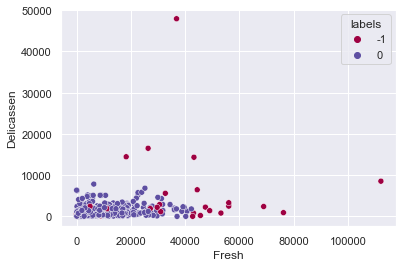

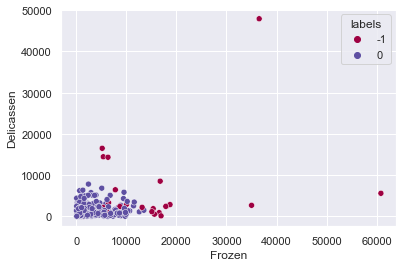

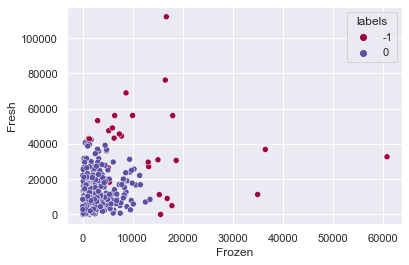

In [14]:
sns.set(style="darkgrid")

sns.scatterplot(df.Fresh, df.Delicassen, hue=df.labels, palette='Spectral')
plt.show()

sns.scatterplot(df.Frozen, df.Delicassen, hue=df.labels, palette='Spectral')
plt.show()

sns.scatterplot(df.Frozen, df.Fresh, hue=df.labels, palette='Spectral')
plt.show()

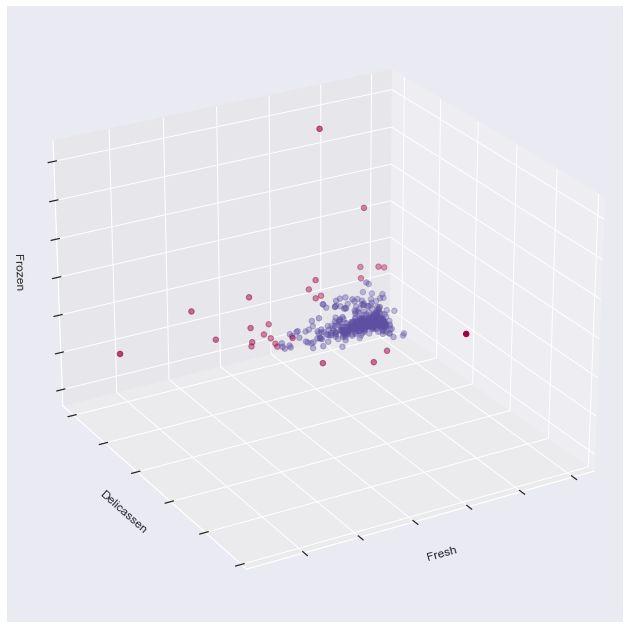

In [15]:
fig = plt.figure(1, figsize=(9, 9))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=60)

# plot the points
ax.scatter(df.Fresh, df.Delicassen, df.Frozen,
           c=df.labels, cmap='Spectral', s=30)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Delicassen')
ax.set_zlabel('Frozen');

#### 2. Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.

In [16]:
def acquire_codeup():
    '''
    Grab our data from path and read as dataframe
    '''
    
    df = pd.read_sql('''
                        select *
                        from logs
                        join cohorts on logs.cohort_id = cohorts.id''', get_db_url('curriculum_logs'))
    return df

In [17]:
df = acquire_codeup()
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        847330 non-null  object 
 1   time        847330 non-null  object 
 2   path        847329 non-null  object 
 3   user_id     847330 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          847330 non-null  object 
 6   id          847330 non-null  int64  
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  int64  
dtypes: float64(1), int64(3), object(11)
memory usage: 97.0+ MB


In [19]:
df.shape

(847330, 15)

In [20]:
# df.index = pd.to_datetime(df.date + " " + df.time)

In [21]:
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2


In [22]:
# rename columns
df.rename(columns={'ip':'ip_address', 'name':'cohort_name', 
                        'path':'webpage_accessed'}, inplace=True)

In [23]:
# merge date and time together and set as index
# df.index = pd.to_datetime(df.date + " " + df.time)

# df = df.drop(columns=['date','time'], axis=1)

In [24]:
df.sample(5)

,date,time,webpage_accessed,user_id,cohort_id,ip_address,id,cohort_name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
241470,2019-05-08,13:29:32,spring/fundamentals/form-model-binding,344,29.0,97.105.19.58,29,Zion,#zion,2019-01-22,2019-06-04,2019-01-20 23:18:57,2019-01-20 23:18:57,None,2
294462,2019-08-13,13:42:12,9-timeseries/4-prep,404,28.0,97.105.19.58,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,None,2
6184,2018-02-07,07:53:15,java-i/syntax-types-and-variables,3,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2
167999,2018-12-17,15:06:46,spring/fundamentals/views,272,26.0,97.105.19.58,26,Xanadu,#xanadu,2018-09-17,2019-02-08,2018-09-17 19:09:51,2018-09-17 19:09:51,None,2
4903,2018-02-04,22:35:27,javascript-i,23,22.0,108.65.244.91,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2


In [25]:
# are there any nulls?
df.isnull().sum()

date                     0
time                     0
webpage_accessed         1
user_id                  0
cohort_id                0
ip_address               0
id                       0
cohort_name              0
slack                    0
start_date               0
end_date                 0
created_at               0
updated_at               0
deleted_at          847330
program_id               0
dtype: int64

In [26]:
# drop deleted_ad columns
df.drop(columns='deleted_at', inplace=True)

# drop the remaining null
df.dropna(inplace=True)

# verify
df.isnull().sum()

date                0
time                0
webpage_accessed    0
user_id             0
cohort_id           0
ip_address          0
id                  0
cohort_name         0
slack               0
start_date          0
end_date            0
created_at          0
updated_at          0
program_id          0
dtype: int64

In [27]:
# create a class type name feature
df['program_type'] = df.program_id.replace({1: 'PHP',
                                           2: 'Java',
                                           3: 'Data Science',
                                           4: 'Front End'})

In [28]:
df.sample(5).T

,723040,65765,275805,651734,6710
date,2021-01-04,2018-06-11,2019-07-17,2020-10-06,2018-02-08
time,09:24:53,09:18:07,17:28:10,10:35:48,08:55:56
webpage_accessed,sql/relationships-overview,java-iii/user-input,2-stats/4.7-correlation,spring/fundamentals/repositories,javascript-i
user_id,845,145,248,315,8
cohort_id,133,23,28,28,22
ip_address,148.66.39.72,97.105.19.61,97.105.19.58,66.69.86.155,97.105.19.61
id,133,23,28,28,22
cohort_name,Easley,Ulysses,Staff,Staff,Teddy
slack,#easley,#ulysses,#,#,#teddy
start_date,2020-12-07,2018-03-05,2014-02-04,2014-02-04,2018-01-08


In [33]:
id_counts = df.groupby(['id'])['cohort_name','webpage_accessed'].nunique()
cohort_counts = df.groupby(['cohort_name'])['webpage_accessed','id'].nunique()
first_access = df.groupby(['id']).min()
# id_by_first_access_date = pd.DataFrame({'first_access_date': first_access}).reset_index().groupby('first_access_date').count()

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.plot(id_by_first_access_date)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
id_counts[id_counts.cohort > 1]